
# Productividad de pozos

Analisis estadístico y simulación de gasto en pozos. 

Información de producción histórica de hidrocarburos de la CNH.

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import scipy.stats
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

import timeit

In [3]:
pd.set_option('display.max_rows', 100_000_000)
pd.set_option('display.max_columns', 100_000_000)
pd.set_option('display.width', 1_000)
pd.set_option('precision', 2)
pd.options.display.float_format = '{:,.2f}'.format

# Función Productividad de pozos

In [26]:
def productividad():
    
    global campo
    global unique_well_list
    global input_campo
    global well_data
    global results
    
    tic=timeit.default_timer()
    
###########      DISTRIBUCION DE PROBABILIDAD   ####### 
    
    class Distribution(object):
    
        def __init__(self,dist_names_list = []):
            self.dist_names = ['beta',
                                'expon',
                                'gamma',
                                'lognorm',
                                'norm',
                                'pearson3',
                                'triang',
                                'uniform',
                                'weibull_min', 
                                'weibull_max']
            self.dist_results = []
            self.params = {}

            self.DistributionName = ""
            self.PValue = 0
            self.Param = None

            self.isFitted = False


        def Fit(self, y):
            self.dist_results = []
            self.params = {}
            for dist_name in self.dist_names:
                dist = getattr(scipy.stats, dist_name)
                param = dist.fit(y)

                self.params[dist_name] = param
                #Applying the Kolmogorov-Smirnov test
                D, p = scipy.stats.kstest(y, dist_name, args=param);
                self.dist_results.append((dist_name,p))
            #select the best fitted distribution
            sel_dist,p = (max(self.dist_results,key=lambda item:item[1]))
            #store the name of the best fit and its p value
            self.DistributionName = sel_dist
            self.PValue = p

            self.isFitted = True
            return self.DistributionName,self.PValue

        def Random(self, n = 1):
            if self.isFitted:
                dist_name = self.DistributionName
                param = self.params[dist_name]
                #initiate the scipy distribution
                dist = getattr(scipy.stats, dist_name)
                return dist.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=n)
            else:
                raise ValueError('Must first run the Fit method.')

        def Plot(self,y):
            x = self.Random(n=len(y))
            fig, ax = plt.subplots(figsize=(16,8))
            plt.hist(x, alpha=0.5, label='Fitted',bins=50)
            plt.hist(y, alpha=0.5, label='Actual',bins=50)
            plt.legend(loc='upper right')

    
#############      ESTADISTICA DE POZOS   ####### 
    
    
    #Carga de datos   
    mx_stats=pd.read_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/mexico/pozos/mx_benchmark.csv',
                         index_col=0,
                         low_memory=False)
    
    display('Numero de datos en BD: '+str(len(mx_stats)))
    
    #Input de campo
    input_campo = input("Nombre de Campo: ")
    
    selected_rows=mx_stats.pozo.str.contains(str(input_campo))
    campo=mx_stats.loc[selected_rows]

    display('Numero de datos para '+str(input_campo)+': ' +str(len(campo)))
    
    unique_well_list=pd.unique(campo['pozo'])

    display('Número de pozos en ' +str(input_campo)+': '+str(len(unique_well_list)),
            unique_well_list)
    
    #Estadistica descriptiva
    display('Percentiles y estadistica descriptiva: ')
    display(campo.aceite_Mbd.quantile([.1,.5,.9]),
            campo.describe())  
    
    #Analisis de dispersion
    fig, ax = plt.subplots(figsize=(16,8))
    ax.scatter(campo.pozo,campo.aceite_Mbd)
    ax.set_xlabel('Pozo')
    ax.set_xticklabels(labels=campo.pozo,rotation=90)
    ax.set_ylabel('Gasto de aceite Mbd')
    plt.show()
    
    #Ajuste de distribucion
    dst=Distribution()
    display(dst.Fit(campo.aceite_Mbd))
    dst.Plot(campo.aceite_Mbd)
    
    #Generacion de archivo de resultados
    campo.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/'+str(input_campo)+str('.csv'))

########      ANALISIS DE DECLINACION DE POZOS      ####### 
    
    def remove_nan_and_zeroes_from_columns(df, variable):
        """
        This function cleans up a dataframe by removing rows in a specific 
        column that are null/NaN or equal to 0. This basically removes zero 
        production time periods.
        Arguments:
        df: Pandas dataframe.
        variable: String. Name of the column where we want to filter out
        NaN's or 0 values
        Output:
        filtered_df: Pandas dataframe. Dataframe with NaN's and zeroes filtered out of 
        the specified column
        """
        filtered_df = df[(df[variable].notnull()) & (df[variable]>0)]
        return filtered_df

    def generate_time_delta_column(df, time_column, date_first_online_column):
        """
        Create column for the time that a well has been online at each reading, with 
        the first non-null month in the series listed as the start of production
        Arguments:
        df: Pandas dataframe
        time_column: String. Name of the column that includes the specific record date
        that the data was taken at. Column type is pandas datetime
        date_first_online_column: Name of the column that includes the date that the
        well came online. Column type is pandas datetime
        Outputs:
        Pandas series containing the difference in days between the date the well
        came online and the date that the data was recorded (cumulative days online)
        """
        df['Dias Produciendo']=(df[time_column]-df[date_first_online_column]).dt.days
        return (df[time_column]-df[date_first_online_column]).dt.days

    def get_min_or_max_value_in_column_by_group(dataframe, group_by_column, calc_column, calc_type):
        global value
        """
        This function obtains the min or max value for a column, with a group by applied. For example,
        it could return the earliest (min) RecordDate for each API number in a dataframe 
        Arguments:
        dataframe: Pandas dataframe 
        group_by_column: string. Name of column that we want to apply a group by to
        calc_column: string. Name of the column that we want to get the aggregated max or min for
        calc_type: string; can be either 'min' or 'max'. Defined if we want to pull the min value 
        or the max value for the aggregated column
        Outputs:
        value: Depends on the calc_column type.
        """
        value=dataframe.groupby(group_by_column)[calc_column].transform(calc_type)
        return value

    def get_max_initial_production(df, number_first_months, variable_column, date_column):
        global df_beginning_production
        """
        This function allows you to look at the first X months of production, and selects 
        the highest production month as max initial production
        Arguments:
        df: Pandas dataframe. 
        number_first_months: float. Number of months from the point the well comes online
        to compare to get the max initial production rate qi (this looks at multiple months
        in case there is a production ramp-up)
        variable_column: String. Column name for the column where we're attempting to get
        the max volume from (can be either 'Gas' or 'Oil' in this script)
        date_column: String. Column name for the date that the data was taken at 
        """
        #First, sort the data frame from earliest to most recent prod date
        df=df.sort_values(by=date_column)
        #Pull out the first x months of production, where number_first_months is x
        df_beginning_production=df.head(number_first_months)
        #Return the max value in the selected variable column from the newly created 
        #df_beginning_production df
        return df_beginning_production[variable_column].max()

    def hyperbolic_equation(t, qi, b, di):
        """
        Hyperbolic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        b: Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/((1.0+b*di*t)**(1.0/b))

    def exponential_equation(t, qi, di):
        """
        Exponential decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi*np.exp(-di*t)

    def harmonic_equation (t, qi, di):
        """
        Harmonic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/(1+(di*t))

    def plot_actual_vs_predicted_by_equations(df, x_variable, y_variables, plot_title):
        """
        This function is used to map x- and y-variables against each other
        Arguments:
        df: Pandas dataframe.
        x_variable: String. Name of the column that we want to set as the 
        x-variable in the plot
        y_variables: string (single), or list of strings (multiple). Name(s) 
        of the column(s) that we want to set as the y-variable in the plot
        """
        #Plot results
        df.plot(x=x_variable, y=y_variables, title=plot_title,figsize=(10,5),scalex=True, scaley=True)
        plt.show()
    
    results=pd.DataFrame()
    #Read the oil and gas data
    well_data=campo
    #Perform some data cleaning to get the columns as the right data type
    well_data['fecha']=pd.to_datetime(well_data['fecha'])
    #Declare the desired product that we want to curve fit for--it can either by 'Gas' or 'Oil'
    hydrocarbon='aceite_Mbd'
    #Remove all rows with null values in the desired time series column
    well_data=remove_nan_and_zeroes_from_columns(well_data, hydrocarbon)
    #Get a list of unique wells to loop through
    unique_well_list=pd.unique(list(well_data.pozo))
    #Get the earliest RecordDate for each Well
    well_data['first_oil']= get_min_or_max_value_in_column_by_group(well_data, group_by_column='pozo', 
                  calc_column='fecha', calc_type='min')
    #Generate column for time online delta
    well_data['days_online']=generate_time_delta_column(well_data, time_column='fecha', 
                  date_first_online_column='first_oil')
    #Pull data that came online between an specified range
    well_data_range=well_data[(well_data.fecha>='1900-01-01') & (well_data.fecha<='2019-12-01')]
    #Loop through each well, and perform calculations
    for pozo in unique_well_list:
        #Subset the dataframe by Well
        production_time_series=well_data_range[well_data_range.pozo==pozo]
        #Get the highest value of production in the first X months of production, to use as qi value
        qi=get_max_initial_production(production_time_series, 12, hydrocarbon, 'fecha')
        #Exponential curve fit the data to get best fit equation
        popt_exp, pcov_exp=curve_fit(exponential_equation, production_time_series['days_online'], 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,10]))
        print('Exponential Fit Curve-fitted Variables: qi='+str(popt_exp[0])+', di='+str(popt_exp[1]))
        #Hyperbolic curve fit the data to get best fit equation
        popt_hyp, pcov_hyp=curve_fit(hyperbolic_equation, production_time_series['days_online'], 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,2,10]))
        print('Hyperbolic Fit Curve-fitted Variables: qi='+str(popt_hyp[0])+', b='+str(popt_hyp[1])+', di='+str(popt_hyp[2]))
        #Harmonic curve fit the data to get best fit equation
        popt_harm, pcov_harm=curve_fit(harmonic_equation, production_time_series['days_online'], 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,10]))
        print('Harmonic Fit Curve-fitted Variables: qi='+str(popt_harm[0])+', di='+str(popt_harm[1]))
        #Exponential fit results
        production_time_series.loc[:,'Exponential_Predicted']=exponential_equation(production_time_series['days_online'], 
                                  *popt_exp)

        #Hyperbolic fit results
        production_time_series.loc[:,'Hyperbolic_Predicted']=hyperbolic_equation(production_time_series['days_online'], 
                                  *popt_hyp)
        #Harmonic fit results
        production_time_series.loc[:,'Harmonic_Predicted']=harmonic_equation(production_time_series['days_online'], 
                                  *popt_harm)
        
        #Error
        perr = np.sqrt(np.diag(pcov_harm))

        production_time_series.loc[:,'Qi_harmonic']=popt_harm[0]
        production_time_series.loc[:,'di_harmonic']=popt_harm[1]
        production_time_series.loc[:,'Error Qo_harmonic']=perr[0]
        production_time_series.loc[:,'Error di_harmonic']=perr[1]
        

        #Declare the x- and y- variables that we want to plot against each other
        y_variables=[hydrocarbon,'Hyperbolic_Predicted','Exponential_Predicted','Harmonic_Predicted']
        x_variable='days_online'
        #Create the plot title
        plot_title=hydrocarbon+' for '+str(pozo)
        #Plot the data to visualize the equation fit
        plot_actual_vs_predicted_by_equations(production_time_series, x_variable, y_variables, plot_title)

        results=results.append(production_time_series,sort=True)
    
    #####################  RESULTADOS DCA   #####################

    results.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/'+str(input_campo)+'_dca.csv')
    
    fig2, ax2 = plt.subplots(figsize=(16,8))
    plt.hist(results.aceite_Mbd, alpha=0.5, label='Qo Historico',bins=50)
    plt.hist(results.Hyperbolic_Predicted, alpha=0.5, label='Hyperbolic Predicted',bins=50)
    plt.legend(loc='upper right')
    
    results=results.groupby(by='pozo')
    fig3, ax3 = plt.subplots(figsize=(16,8))
    ax3.scatter(results.days_online,results.aceite_Mbd,cmap='viridis')
    ax3.set_xlabel('Dias Produciendo')
    ax3.set_ylabel('Qo')
    plt.show()

    toc=timeit.default_timer()
    tac= toc - tic #elapsed time in seconds

    return display('Tiempo de procesamiento: ' +str(tac)+' segundos')

'Numero de datos en BD: 2838332'

Nombre de Campo: ZAAP


'Numero de datos para ZAAP: 8660'

'Número de pozos en ZAAP: 81'

array(['ZAAP-2051', 'ZAAP-2032', 'ZAAP-3D', 'ZAAP-5D', 'ZAAP-1001',
       'ZAAP-106', 'ZAAP-7DA', 'ZAAP-27D', 'ZAAP-22D', 'ZAAP-95',
       'ZAAP-108', 'ZAAP-23D', 'ZAAP-2031', 'ZAAP-20', 'ZAAP-36',
       'ZAAP-25D', 'ZAAP-18', 'ZAAP-24', 'ZAAP-38', 'ZAAP-4', 'ZAAP-48',
       'ZAAP-10', 'ZAAP-12', 'ZAAP-26', 'ZAAP-16', 'ZAAP-32', 'ZAAP-128',
       'ZAAP-22', 'ZAAP-25', 'ZAAP-27', 'ZAAP-8', 'ZAAP-2', 'ZAAP-58',
       'ZAAP-14', 'ZAAP-28', 'ZAAP-30', 'ZAAP-41', 'ZAAP-9', 'ZAAP-6D',
       'ZAAP-43', 'ZAAP-118', 'ZAAP-6', 'ZAAP-44', 'ZAAP-1003', 'ZAAP-11',
       'ZAAP-5', 'ZAAP-210', 'ZAAP-111', 'ZAAP-208', 'ZAAP-21',
       'ZAAP-110D', 'ZAAP-29D', 'ZAAP-114D', 'ZAAP-103', 'ZAAP-31D',
       'ZAAP-15', 'ZAAP-33D', 'ZAAP-116D', 'ZAAP-50', 'ZAAP-34',
       'ZAAP-35', 'ZAAP-126', 'ZAAP-19', 'ZAAP-46D', 'ZAAP-51', 'ZAAP-90',
       'ZAAP-52', 'ZAAP-54', 'ZAAP-68', 'ZAAP-42', 'ZAAP-62', 'ZAAP-78',
       'ZAAP-72DES', 'ZAAP-56DES', 'ZAAP-66DES', 'ZAAP-53DES',
       'ZAAP-115DES', 'ZAA

'Percentiles y estadistica descriptiva: '

0.10   1.78
0.50   5.21
0.90   9.03
Name: aceite_Mbd, dtype: float64

,aceite_Mbd,agua_Mbd,condensado_Mbd,gas_asociado_MMpcd,gas_no_asociado_MMpcd
count,"8,660.00","8,660.00","8,660.00","8,660.00","8,660.00"
mean,5.39,0.02,0.00,2.59,0.00
std,2.90,0.13,0.00,3.47,0.00
min,0.00,0.00,0.00,0.00,0.00
25%,3.24,0.00,0.00,1.09,0.00
50%,5.21,0.00,0.00,1.84,0.00
75%,7.25,0.00,0.00,2.82,0.00
max,17.01,2.57,0.00,53.74,0.00


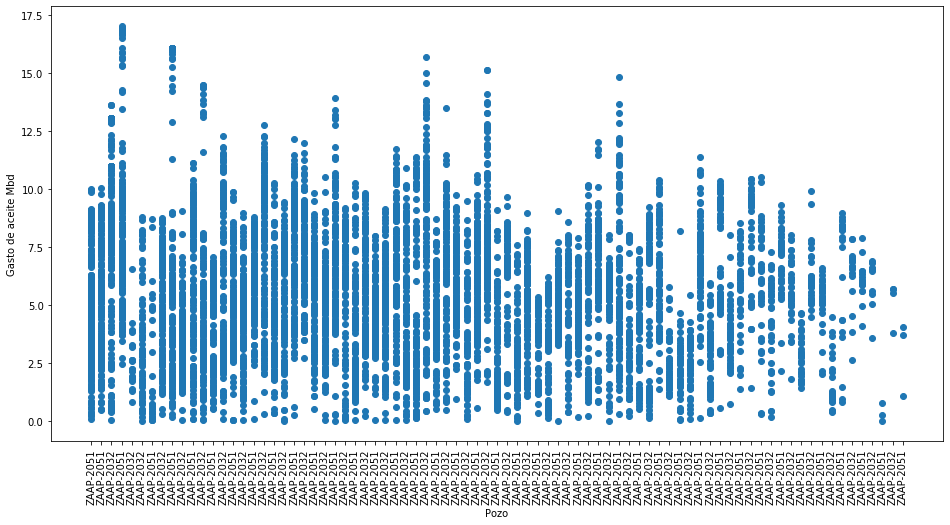

('weibull_min', 0.001444128327957998)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:250: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Exponential Fit Curve-fitted Variables: qi=0.521062582594345, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=3.9583869999999997, b=1.9999817086958092, di=2.0464198322731412e-20
Harmonic Fit Curve-fitted Variables: qi=3.958386999999995, di=9.86819360172889e-20


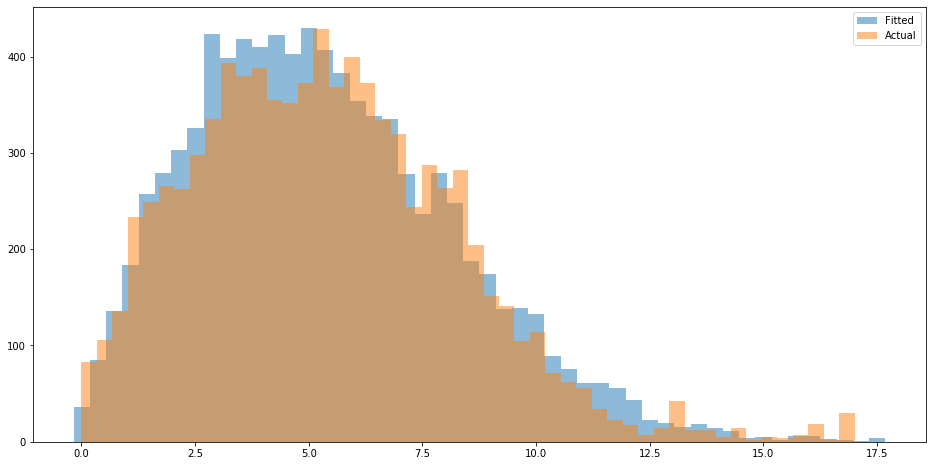

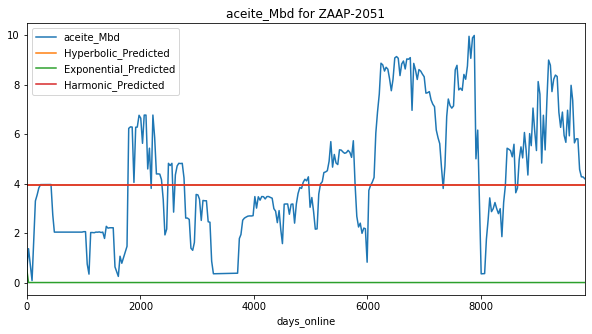

Exponential Fit Curve-fitted Variables: qi=2.7337166508458264, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=2.7550329999999996, b=1.9999999999999998, di=1.5734368694661569e-21
Harmonic Fit Curve-fitted Variables: qi=2.7550329999999996, di=4.7763634544959734e-24


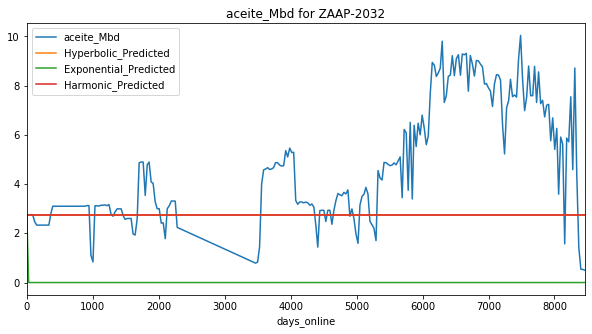

Exponential Fit Curve-fitted Variables: qi=9.101566343681531, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=12.038366961026506, b=0.17285179107926799, di=0.0001245882408545537
Harmonic Fit Curve-fitted Variables: qi=12.133332999999505, di=0.00015853194110535516


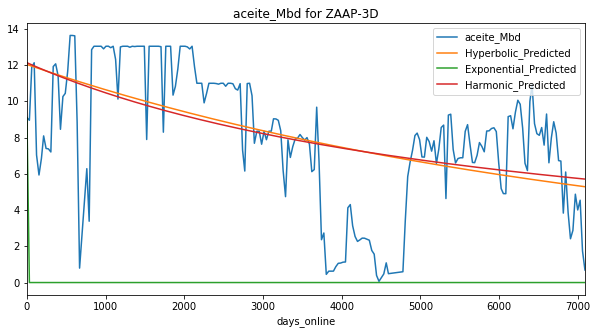

Exponential Fit Curve-fitted Variables: qi=6.482902424963514, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=9.388064999967881, b=8.307039917495972e-08, di=3.4731966896787174e-05
Harmonic Fit Curve-fitted Variables: qi=9.388064999998479, di=3.5385362789781744e-05


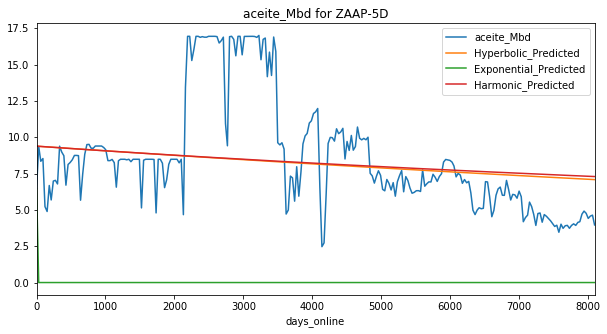

Exponential Fit Curve-fitted Variables: qi=6.56142449798584, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.643355150895791, b=1.9999999999999998, di=0.007154535388584598
Harmonic Fit Curve-fitted Variables: qi=4.901260692460908, di=0.0029842212066337


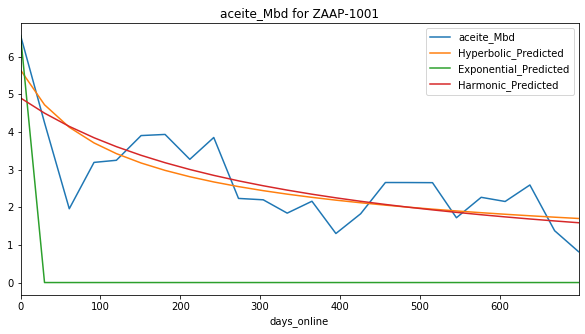

Exponential Fit Curve-fitted Variables: qi=2.798773999086986, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=3.3616925697999993, b=1.9999999999999998, di=1.643571888223686e-24
Harmonic Fit Curve-fitted Variables: qi=3.3616925671401954, di=3.976995195859437e-18


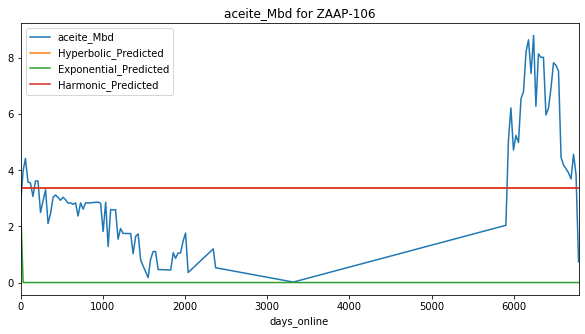

Exponential Fit Curve-fitted Variables: qi=0.06858110035806854, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=2.913492310535448, b=1.376220672099673e-12, di=0.0001740160429215826
Harmonic Fit Curve-fitted Variables: qi=2.837441869094811, di=0.00016556292184039648


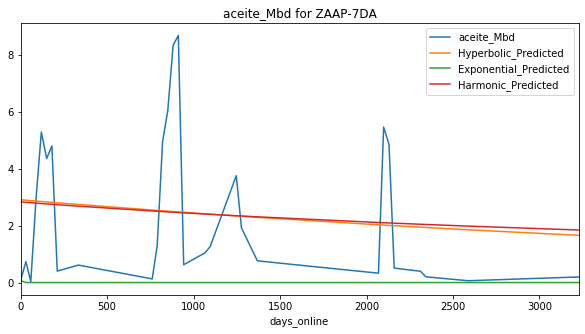

Exponential Fit Curve-fitted Variables: qi=2.409806845539369, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=7.523157033987556, b=2.479129776192872e-13, di=7.311715399888458e-05
Harmonic Fit Curve-fitted Variables: qi=7.3026582415260135, di=8.155611473369558e-05


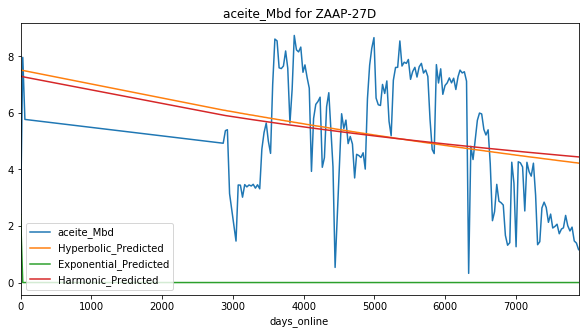

Exponential Fit Curve-fitted Variables: qi=8.13797377074807, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=16.066439999999997, b=0.33786333991382755, di=0.0005363875789874507
Harmonic Fit Curve-fitted Variables: qi=16.066439999999997, di=0.0007918872929297288


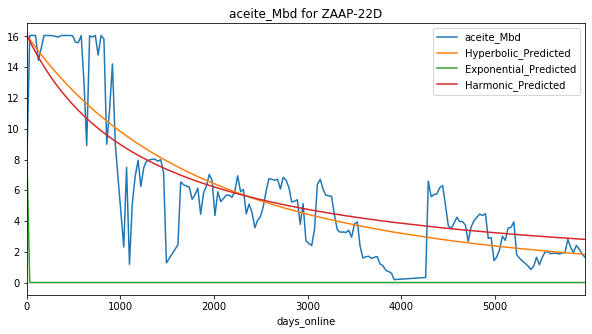

Exponential Fit Curve-fitted Variables: qi=0.07419905404530343, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=2.4260569999993384, b=1.9999999999999998, di=3.277192808767981e-15
Harmonic Fit Curve-fitted Variables: qi=2.4260569999999997, di=7.197715937149613e-21


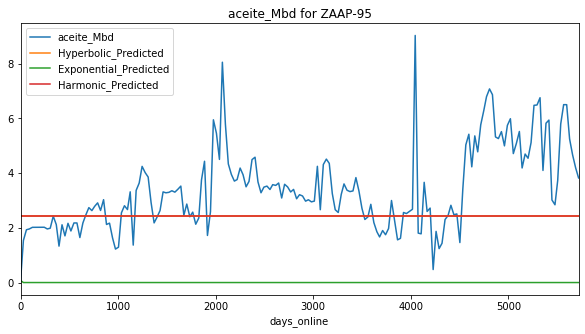

Exponential Fit Curve-fitted Variables: qi=1.3293795316257992, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=1.6011599999999966, b=1.8450908441103309e-06, di=1.171067788159488e-16
Harmonic Fit Curve-fitted Variables: qi=1.6011599999999997, di=1.8595074615478474e-19


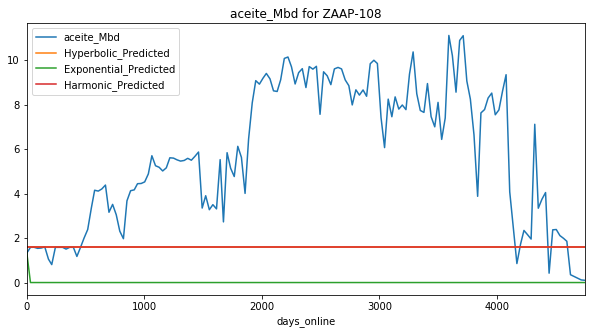

Exponential Fit Curve-fitted Variables: qi=1.0273902312732, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=13.524794362248349, b=1.3379847060128898, di=0.0010295871694930563
Harmonic Fit Curve-fitted Variables: qi=12.930993957203233, di=0.0007680095911890004


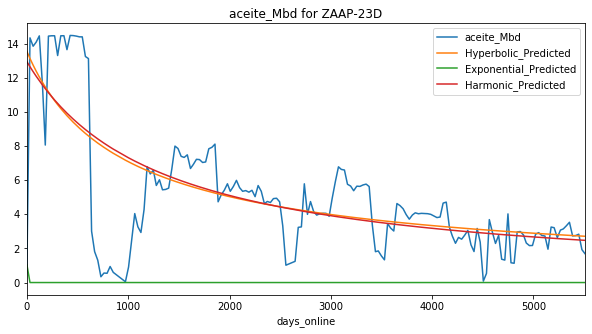

Exponential Fit Curve-fitted Variables: qi=1.3966687776230295, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=1.7521149999999999, b=1.9999999999999998, di=2.7436222694280464e-19
Harmonic Fit Curve-fitted Variables: qi=1.7521149999999999, di=1.2309436052166602e-22


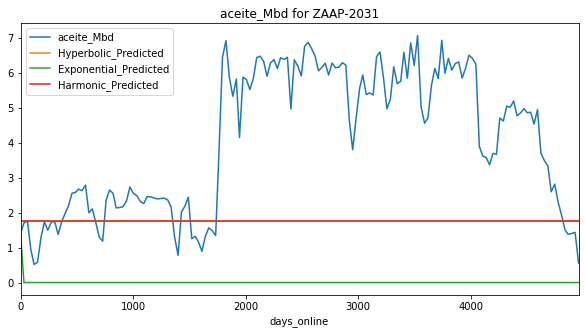

Exponential Fit Curve-fitted Variables: qi=3.924835000198481, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=10.158026999999656, b=1.4847649615512372e-08, di=0.00024131802086882186
Harmonic Fit Curve-fitted Variables: qi=10.158026999999805, di=0.00033776641230537634


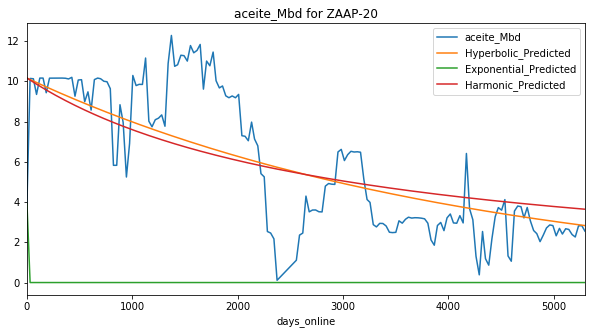

Exponential Fit Curve-fitted Variables: qi=2.6599770500821327, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.383009999999999, b=3.6594400511772024e-14, di=6.187704255809358e-05
Harmonic Fit Curve-fitted Variables: qi=5.383009999999761, di=6.517011284921726e-05


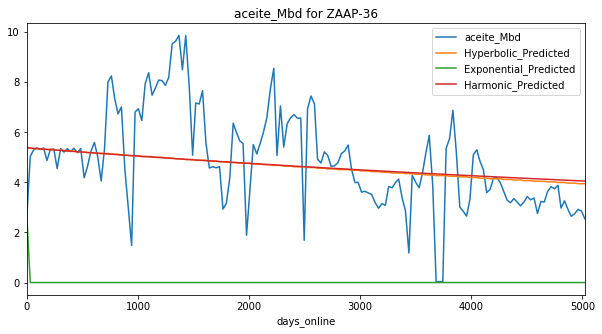

Exponential Fit Curve-fitted Variables: qi=5.455727994670012, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.252258159337171, b=1.2038062673482826e-11, di=0.00014111659306525627
Harmonic Fit Curve-fitted Variables: qi=6.21036987667699, di=0.0001679843921554574


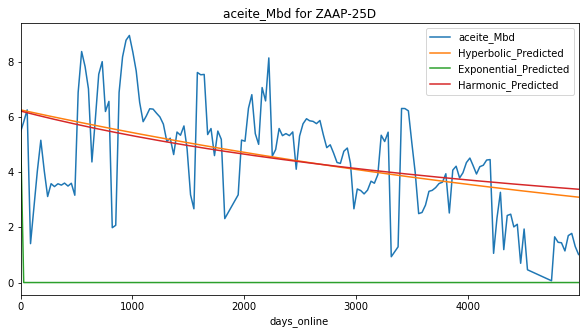

Exponential Fit Curve-fitted Variables: qi=0.11212817969210692, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.9661498437002685, b=1.999905471319404, di=7.53150063385146e-21
Harmonic Fit Curve-fitted Variables: qi=5.966148987280156, di=4.417530784422608e-20


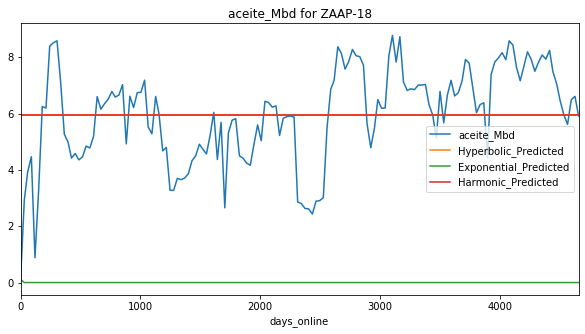

Exponential Fit Curve-fitted Variables: qi=0.3268756440976686, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=8.178703521632116, b=2.8818204069873116e-06, di=2.796990541341247e-05
Harmonic Fit Curve-fitted Variables: qi=8.092603814461077, di=2.4154910695649442e-05


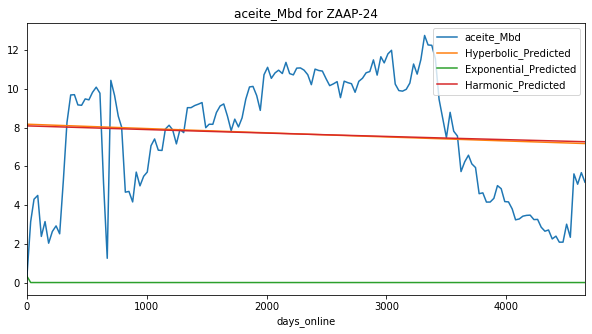

Exponential Fit Curve-fitted Variables: qi=1.2078740620231885, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.132529370602738, b=1.2939917309645188, di=0.00019215768217121197
Harmonic Fit Curve-fitted Variables: qi=6.096667526241347, di=0.00017646513463488817


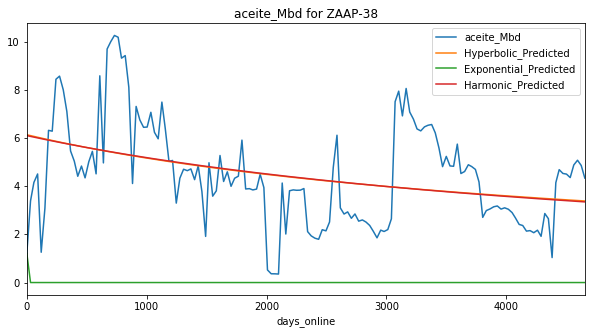

Exponential Fit Curve-fitted Variables: qi=2.5463550010901845, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.879261930001689, b=4.596062764243756e-08, di=0.00012123577152531582
Harmonic Fit Curve-fitted Variables: qi=6.879261999999993, di=0.00013826862910296006


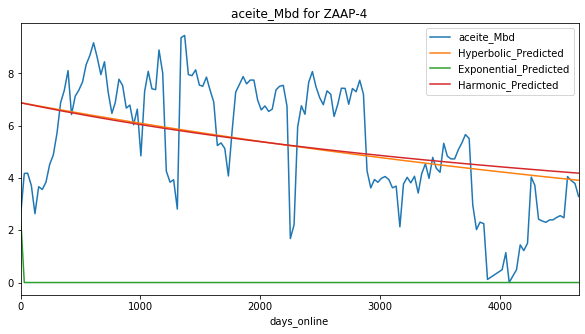

Exponential Fit Curve-fitted Variables: qi=0.2814206259294588, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.505825999999999, b=1.9999999999999998, di=1.9139306224942305e-20
Harmonic Fit Curve-fitted Variables: qi=6.5058259999926085, di=1.0285730879946646e-16


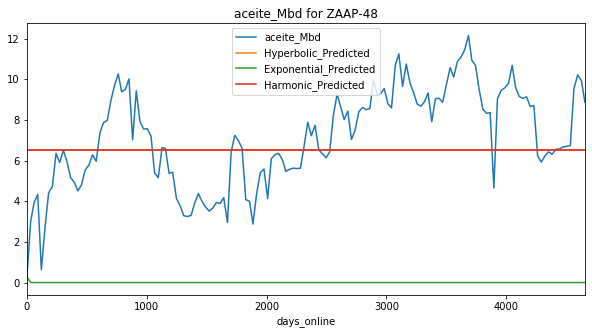

Exponential Fit Curve-fitted Variables: qi=3.501846060206541, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=7.084818999999999, b=2.273355892423723e-07, di=6.53380742872586e-20
Harmonic Fit Curve-fitted Variables: qi=7.084818999846407, di=2.5040966576939194e-16


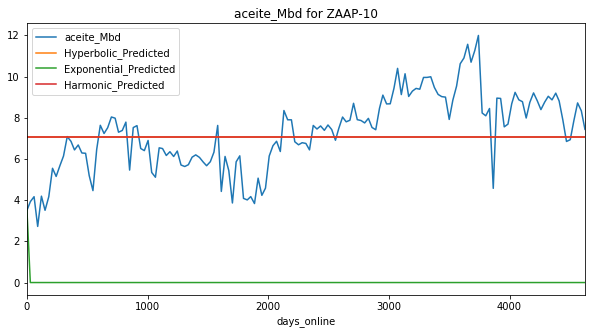

Exponential Fit Curve-fitted Variables: qi=3.244548007469586, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.734240389254107, b=1.5325612187720264e-07, di=9.375272037887274e-05
Harmonic Fit Curve-fitted Variables: qi=6.656426843376252, di=0.00010034226739116814


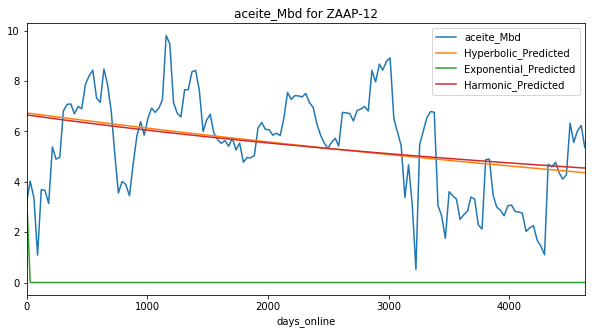

Exponential Fit Curve-fitted Variables: qi=0.06266681570845957, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.506975816701446, b=2.1386771182991198e-14, di=0.00014164042141048865
Harmonic Fit Curve-fitted Variables: qi=6.437870461376641, di=0.00016533878878316924


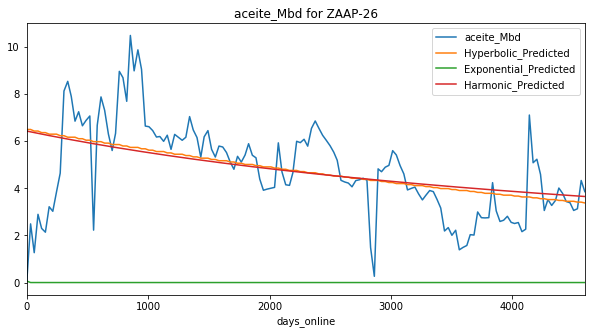

Exponential Fit Curve-fitted Variables: qi=0.33344952418048635, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.392362999664859, b=1.9999999999999412, di=1.2317639995554573e-18
Harmonic Fit Curve-fitted Variables: qi=5.392362999999861, di=1.395222329667157e-17


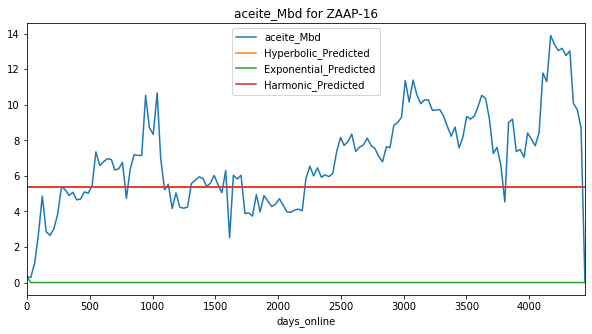

Exponential Fit Curve-fitted Variables: qi=0.1960327681486055, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.948927461445848, b=1.8521018043710333e-06, di=1.543654861094554e-05
Harmonic Fit Curve-fitted Variables: qi=5.93483675254536, di=1.4485687130489905e-05


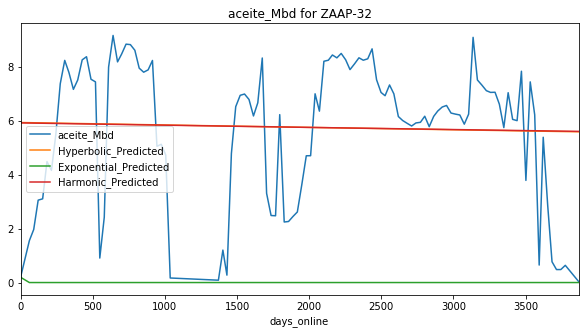

Exponential Fit Curve-fitted Variables: qi=0.04363813076368958, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.444461434381063, b=1.1926111115129862e-07, di=0.0003062549503775846
Harmonic Fit Curve-fitted Variables: qi=6.375742348641063, di=0.0004317463394919219


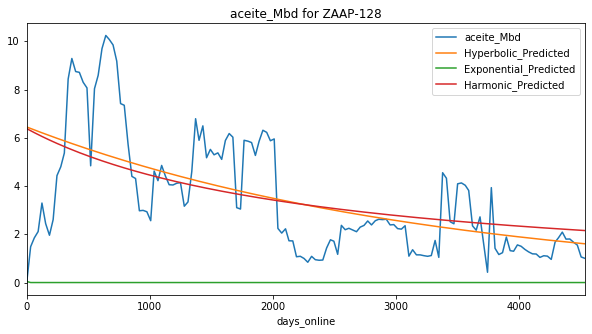

Exponential Fit Curve-fitted Variables: qi=0.21700158405163525, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.9465673148872655, b=1.783720180998267e-05, di=2.2156575635810732e-05
Harmonic Fit Curve-fitted Variables: qi=5.900544509323009, di=1.923755020439859e-05


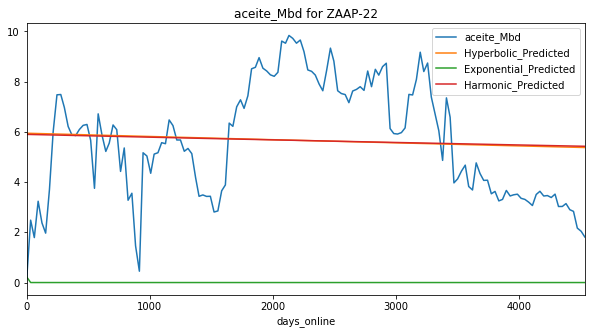

Exponential Fit Curve-fitted Variables: qi=0.034487308147291326, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=4.706122266725027, b=5.758959199135195e-06, di=1.3815289405397715e-05
Harmonic Fit Curve-fitted Variables: qi=4.701868926302755, di=1.3682969572286804e-05


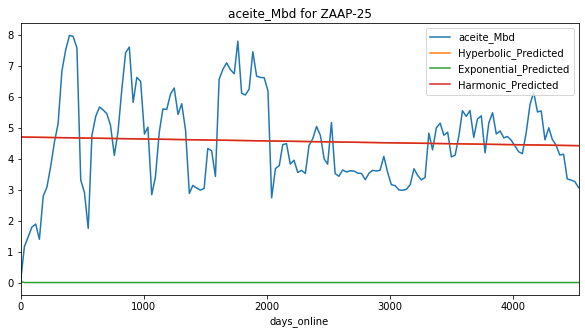

Exponential Fit Curve-fitted Variables: qi=0.03432002558911268, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=4.847009541928792, b=1.6482630154603846, di=2.57130467647643e-19
Harmonic Fit Curve-fitted Variables: qi=4.847009540978803, di=8.019495835279623e-19


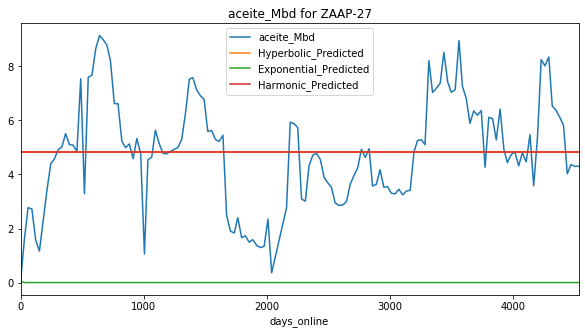

Exponential Fit Curve-fitted Variables: qi=0.04938774585320272, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.804860631295755, b=6.143826304256042e-06, di=1.5132280298542429e-15
Harmonic Fit Curve-fitted Variables: qi=6.804860629325103, di=9.023561827314686e-18


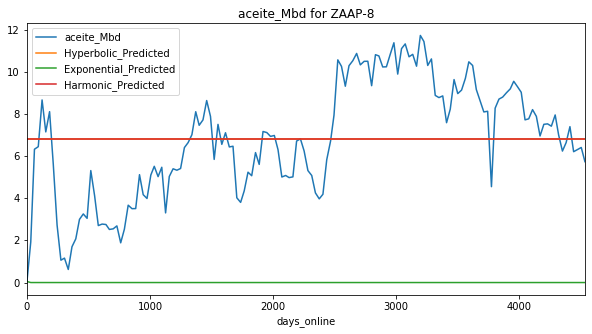

Exponential Fit Curve-fitted Variables: qi=0.20653899026473088, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.868951032052497, b=1.9654576539062623, di=0.00022691730367959813
Harmonic Fit Curve-fitted Variables: qi=6.714049824587134, di=0.00016826686029141865


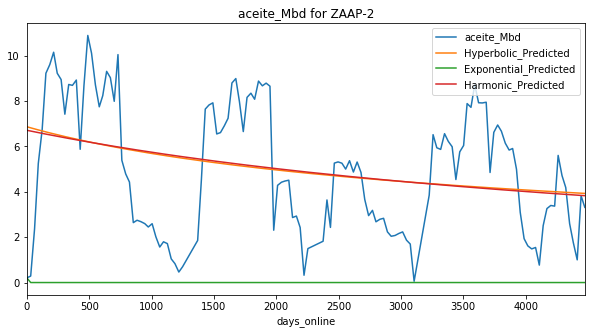

Exponential Fit Curve-fitted Variables: qi=1.739414650554464, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=3.3152289999999995, b=1.9999891058083015, di=1.1220438492940536e-19
Harmonic Fit Curve-fitted Variables: qi=3.3152289999992957, di=7.6295468066872e-17


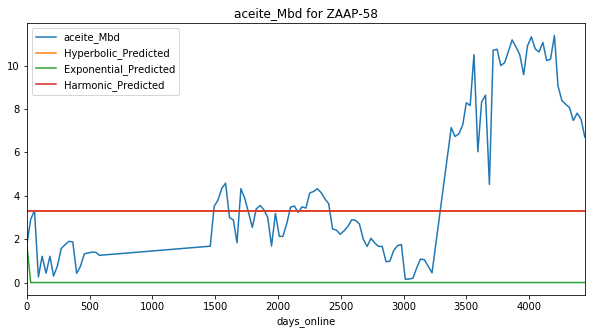

Exponential Fit Curve-fitted Variables: qi=0.4621392119403908, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=8.576914999788922, b=4.233643126649956e-08, di=6.223592672978334e-05
Harmonic Fit Curve-fitted Variables: qi=8.576914999999994, di=6.168090503980737e-05


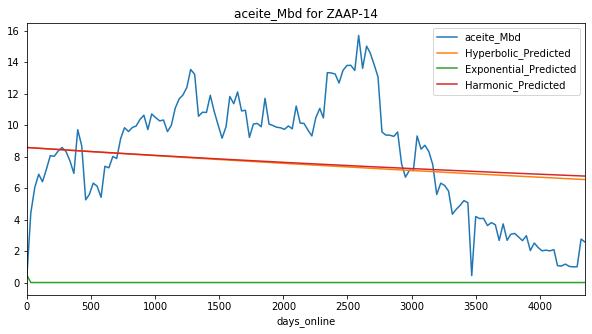

Exponential Fit Curve-fitted Variables: qi=1.7824930009594873, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=4.473876028197883, b=1.9956957884138784, di=2.4516083306318562e-20
Harmonic Fit Curve-fitted Variables: qi=4.473875982890231, di=2.924893808015279e-17


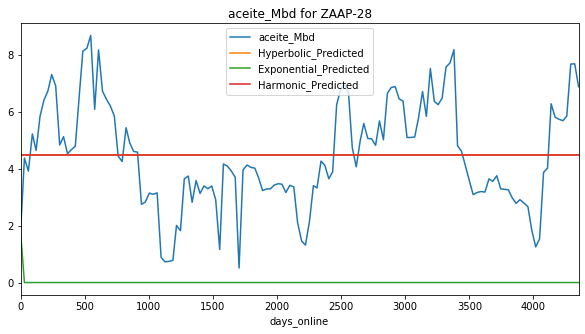

Exponential Fit Curve-fitted Variables: qi=0.49997107202369284, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.5459023262175196, b=0.0010942737395032154, di=1.5225015333193235e-16
Harmonic Fit Curve-fitted Variables: qi=6.54590228386014, di=5.764931745533251e-24


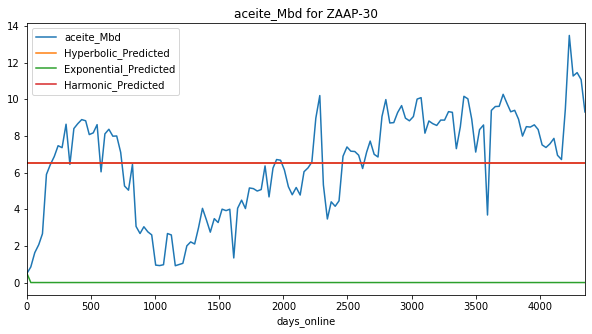

Exponential Fit Curve-fitted Variables: qi=0.9566612994063258, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.756585604623768, b=1.2546152067758158, di=2.0087793976049374e-20
Harmonic Fit Curve-fitted Variables: qi=5.756585604972028, di=5.90694077977943e-23


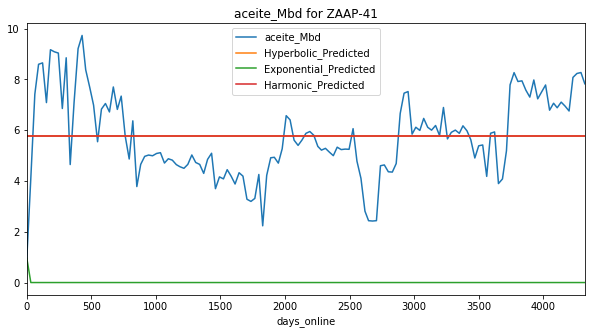

Exponential Fit Curve-fitted Variables: qi=0.2082421261397867, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.4421971604869155, b=5.034963594682965e-08, di=0.00041031224699707034
Harmonic Fit Curve-fitted Variables: qi=6.36351762299666, di=0.0005359460958428525


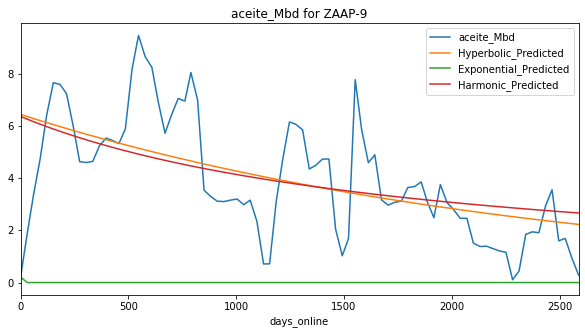

Exponential Fit Curve-fitted Variables: qi=0.5807560300787448, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=7.048134408958474, b=4.31113394253202e-09, di=6.681261912856567e-05
Harmonic Fit Curve-fitted Variables: qi=7.007522409823951, di=6.973857246392167e-05


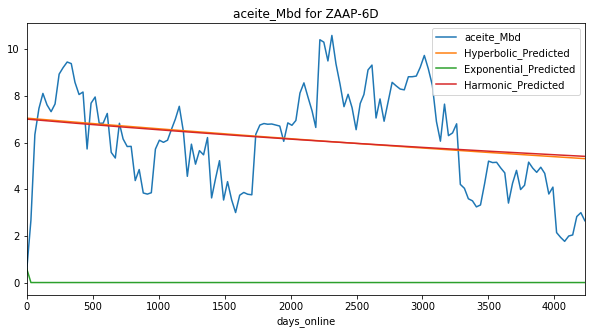

Exponential Fit Curve-fitted Variables: qi=1.6932315427109172, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=7.997934982425479, b=0.0018228947713923027, di=9.910383333089101e-16
Harmonic Fit Curve-fitted Variables: qi=7.997934948021583, di=2.8340475379045196e-24


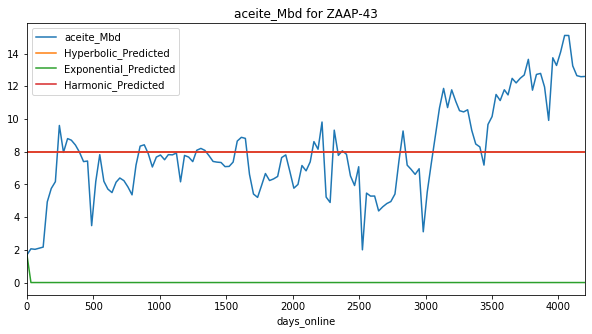

Exponential Fit Curve-fitted Variables: qi=0.6022720075937357, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.487526698710565, b=2.3411379376292384e-08, di=0.00034689040246869724
Harmonic Fit Curve-fitted Variables: qi=5.473086041857669, di=0.0005008882720980587


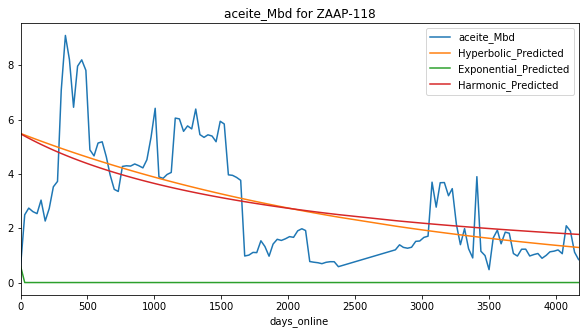

Exponential Fit Curve-fitted Variables: qi=1.1366280427001139, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.492123999999999, b=3.519219595737866e-07, di=1.0655896199637354e-18
Harmonic Fit Curve-fitted Variables: qi=5.492123999998245, di=1.8289257335427865e-15


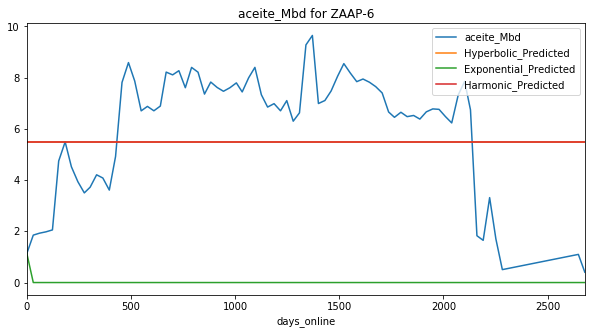

Exponential Fit Curve-fitted Variables: qi=0.12819922343872345, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=3.1921948839421166, b=0.007690003210588658, di=4.329494675612029e-14
Harmonic Fit Curve-fitted Variables: qi=3.19219483567392, di=1.0878715514761842e-20


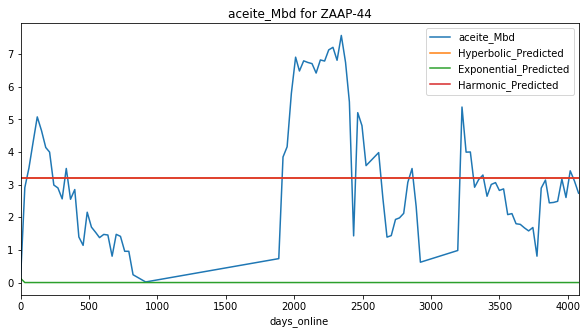

Exponential Fit Curve-fitted Variables: qi=2.5276365889067174, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.305429078806542, b=1.9999999999997196, di=0.00016034972612337226
Harmonic Fit Curve-fitted Variables: qi=6.187757742957041, di=0.0001241651418799496


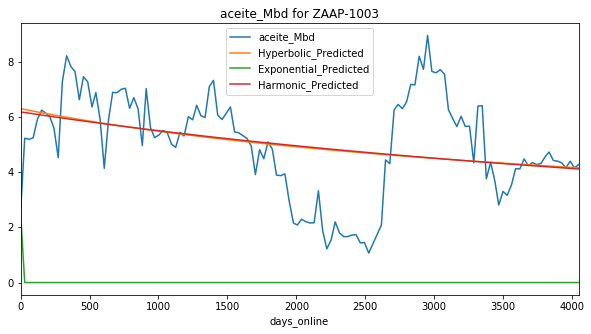

Exponential Fit Curve-fitted Variables: qi=2.2413620512127856, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=4.209899546532927, b=6.26134126105576e-07, di=0.00023256731536636108
Harmonic Fit Curve-fitted Variables: qi=4.132292981850225, di=0.00024324703553396435


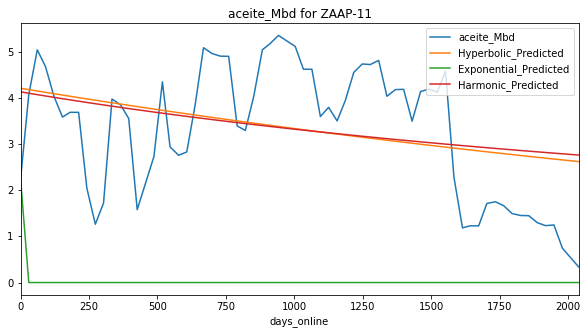

Exponential Fit Curve-fitted Variables: qi=3.2535549831999617, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.946516999468488, b=1.54820044018671e-09, di=0.0005333798069474935
Harmonic Fit Curve-fitted Variables: qi=5.946516999999986, di=0.0007805926638788114


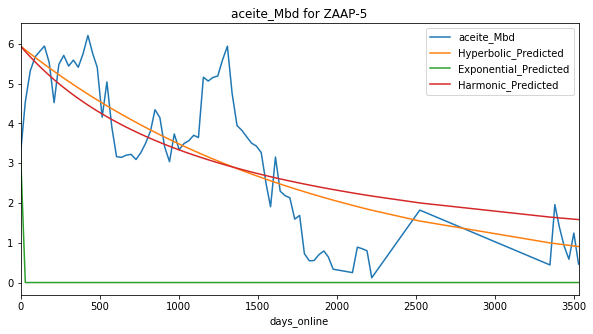

Exponential Fit Curve-fitted Variables: qi=0.018894143686416735, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.0096542509976665, b=0.017872127376931557, di=1.6717611375211626e-13
Harmonic Fit Curve-fitted Variables: qi=5.009653648075587, di=7.77903252673615e-18


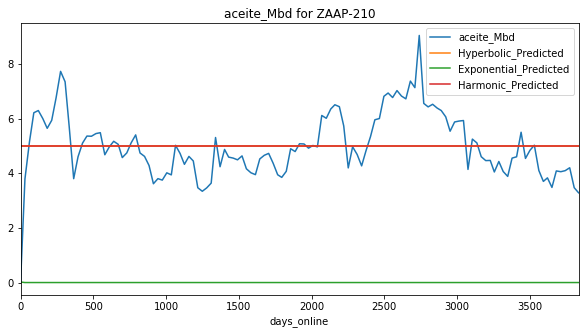

Exponential Fit Curve-fitted Variables: qi=0.3871071124329998, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.561152840587946, b=2.690140948386115e-10, di=0.0003265614146454733
Harmonic Fit Curve-fitted Variables: qi=6.515083723660611, di=0.0003933909253956117


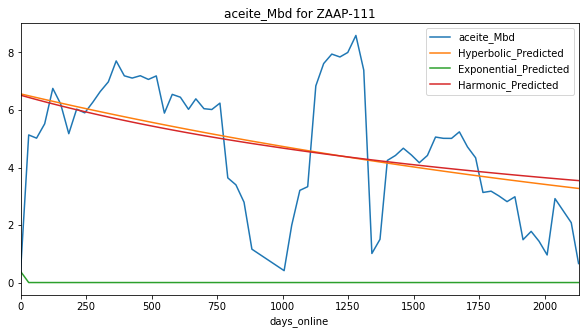

Exponential Fit Curve-fitted Variables: qi=0.17356535997444497, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=4.141245999999999, b=1.9999999999999998, di=2.296708585046876e-18
Harmonic Fit Curve-fitted Variables: qi=4.141245999999308, di=1.1784816704193252e-15


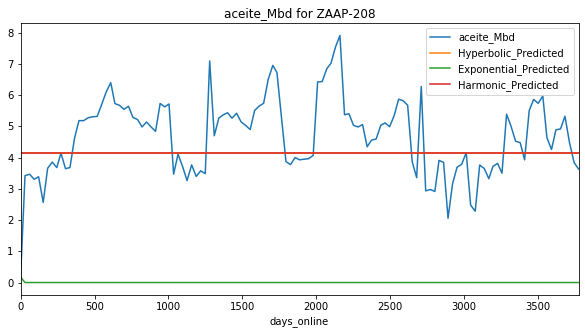

Exponential Fit Curve-fitted Variables: qi=2.060017001134239, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=7.916781664781087, b=6.098860623578871e-11, di=0.000310015472807868
Harmonic Fit Curve-fitted Variables: qi=7.740504047544654, di=0.00038585787963891057


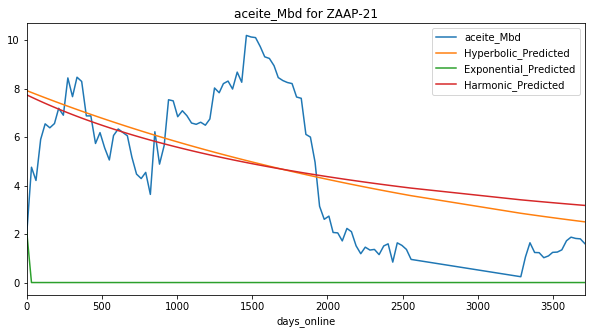

Exponential Fit Curve-fitted Variables: qi=3.726187323746804, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=9.369261876942879, b=0.8412364810509868, di=0.00026772831912049225
Harmonic Fit Curve-fitted Variables: qi=9.411092814829328, di=0.0002826742423163969


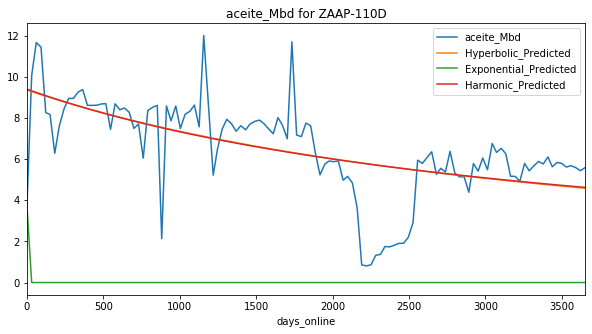

Exponential Fit Curve-fitted Variables: qi=0.42431301424498197, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.247365753560914, b=7.181208963355112e-12, di=0.00014057168935376158
Harmonic Fit Curve-fitted Variables: qi=6.171158995676268, di=0.0001490289795048089


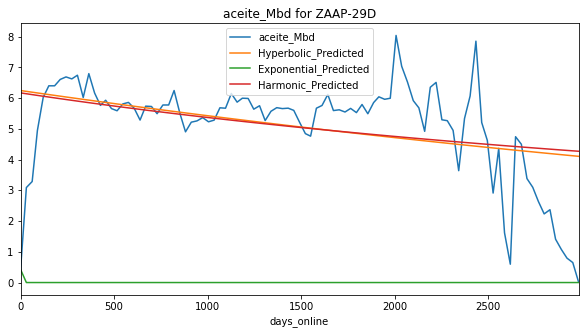

Exponential Fit Curve-fitted Variables: qi=0.9503702011962539, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=3.7964619999999996, b=1.9991044252497054, di=7.671270231094586e-19
Harmonic Fit Curve-fitted Variables: qi=3.7964619999999814, di=7.709663810138557e-18


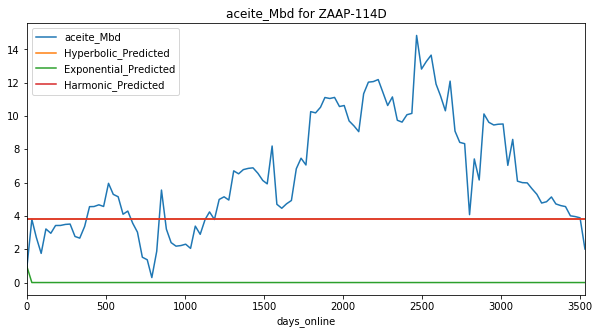

Exponential Fit Curve-fitted Variables: qi=0.4118283876436504, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.342309377915116, b=1.6704476815816886e-12, di=0.00043124711269470003
Harmonic Fit Curve-fitted Variables: qi=5.675513639751348, di=0.0006942292606633692


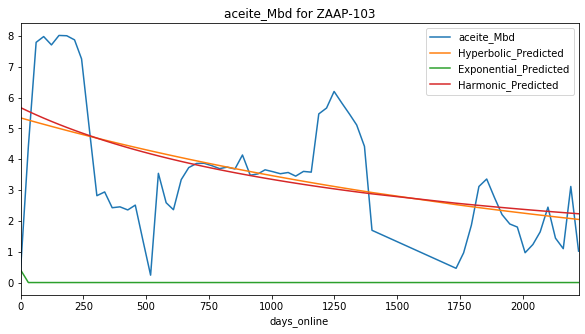

Exponential Fit Curve-fitted Variables: qi=1.428398003151143, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.162188999946544, b=2.9795411617596807e-08, di=0.0003829902619121812
Harmonic Fit Curve-fitted Variables: qi=6.162188999999996, di=0.0005167843337017955


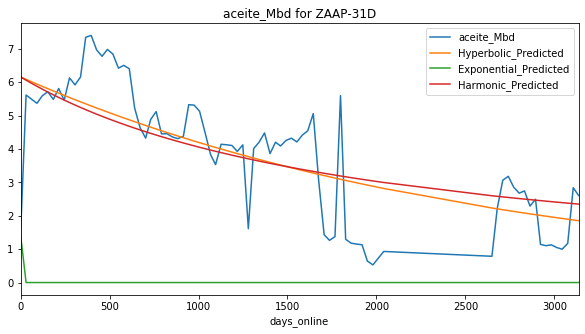

Exponential Fit Curve-fitted Variables: qi=2.5151973515624997, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=2.5176559999999997, b=4.1874064632407837e-10, di=1.1808453589108043e-21
Harmonic Fit Curve-fitted Variables: qi=2.5176559999999966, di=6.5769650852395315e-18


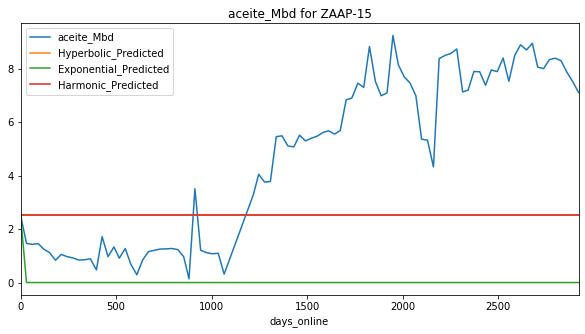

Exponential Fit Curve-fitted Variables: qi=1.7691760007749675, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.121864779206567, b=1.999772827760596, di=2.0367445945038246e-21
Harmonic Fit Curve-fitted Variables: qi=6.121864455379311, di=5.117002714574623e-25


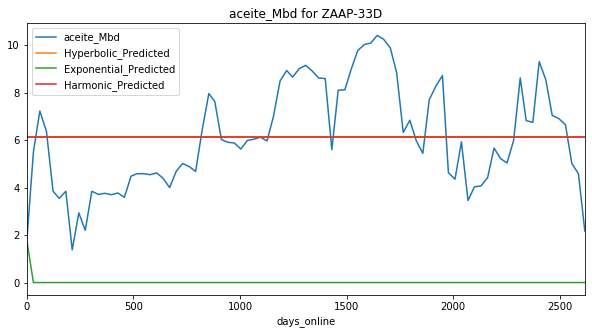

Exponential Fit Curve-fitted Variables: qi=3.0697159995778733, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=2.3482704741331752, b=1.999772900419623, di=1.9190737320646062e-14
Harmonic Fit Curve-fitted Variables: qi=2.348270447280063, di=6.298787531368028e-15


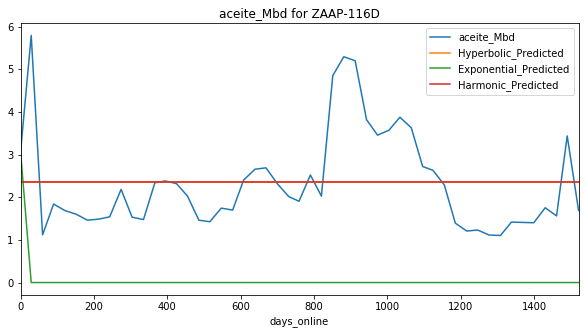

Exponential Fit Curve-fitted Variables: qi=0.43822221871711264, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=3.2464266078462196, b=4.011553106345748e-07, di=0.00028981814775486505
Harmonic Fit Curve-fitted Variables: qi=3.283003782312387, di=0.0003634171501509056


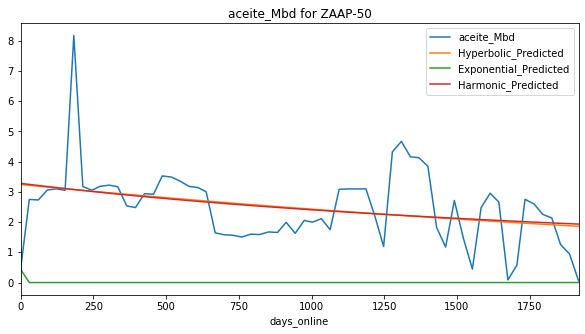

Exponential Fit Curve-fitted Variables: qi=0.34892400812699903, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=2.5250044376100598, b=1.6482032242934181, di=7.552187283685559e-20
Harmonic Fit Curve-fitted Variables: qi=2.52500443685167, di=6.948254304146556e-15


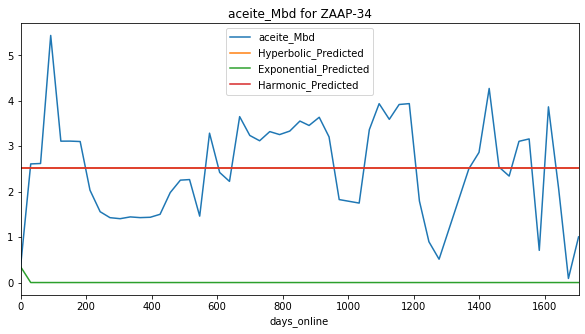

Exponential Fit Curve-fitted Variables: qi=0.12505672583193833, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.7136936868035, b=2.4821674526886994e-06, di=7.690615693490184e-15
Harmonic Fit Curve-fitted Variables: qi=6.713693806482783, di=1.766378440479467e-17


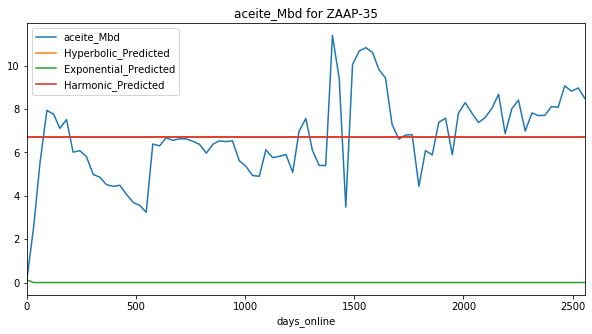

Exponential Fit Curve-fitted Variables: qi=2.302086019559447, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=2.7400765153078286, b=1.999999999999983, di=2.1849727800620494e-17
Harmonic Fit Curve-fitted Variables: qi=2.740076514930298, di=7.620751961921306e-19


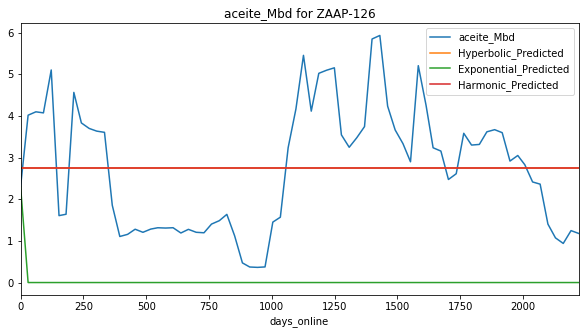

Exponential Fit Curve-fitted Variables: qi=0.5797671510816957, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.497662999995637, b=1.9854964782039628, di=3.4207065463812806e-15
Harmonic Fit Curve-fitted Variables: qi=5.497662999999365, di=2.869822615682446e-17


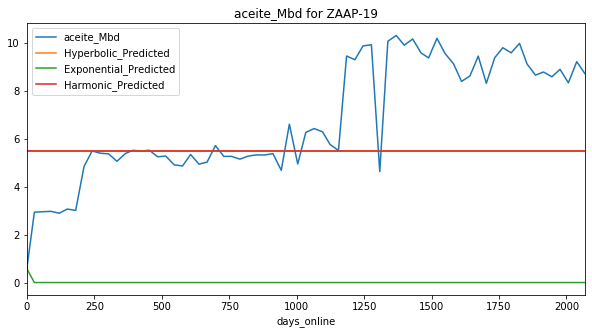

Exponential Fit Curve-fitted Variables: qi=2.356376169394515, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=3.8037496657332377, b=3.3320908587874953e-07, di=1.370984822681503e-18
Harmonic Fit Curve-fitted Variables: qi=3.803749667077802, di=9.095282188545794e-17


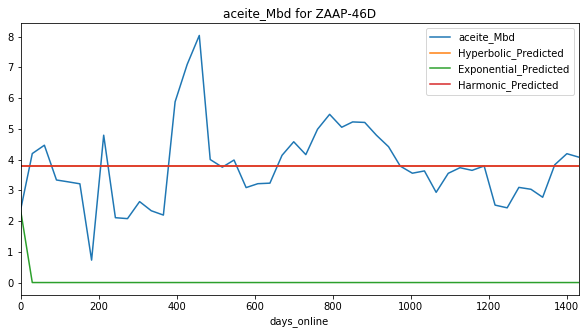

Exponential Fit Curve-fitted Variables: qi=3.431987730325971, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.908105172989628, b=5.640184363403763e-05, di=3.7573631741140995e-05
Harmonic Fit Curve-fitted Variables: qi=5.90079925513645, di=3.620024477100558e-05


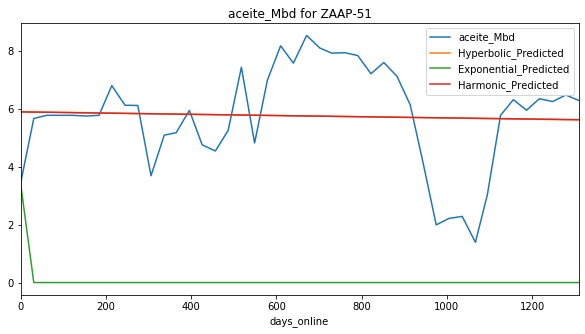

Exponential Fit Curve-fitted Variables: qi=1.4392401465050209, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=7.777653775961592, b=1.9999999999999998, di=3.2100063024207003e-21
Harmonic Fit Curve-fitted Variables: qi=7.777653775961348, di=3.7423216855069466e-19


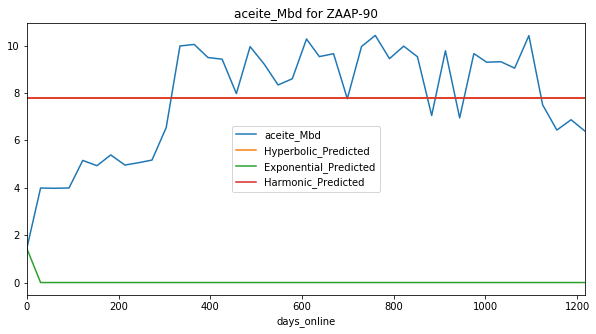

Exponential Fit Curve-fitted Variables: qi=0.36027311874904155, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.388002923046149, b=0.008730701981078792, di=3.998521754905642e-06
Harmonic Fit Curve-fitted Variables: qi=6.386153244106989, di=3.51520750872574e-06


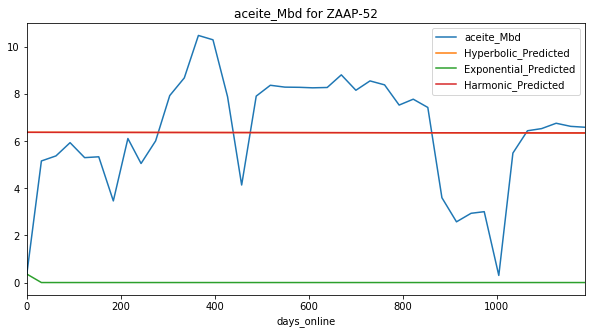

Exponential Fit Curve-fitted Variables: qi=0.1661774339819636, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.373386589045469, b=4.893981503684837e-13, di=0.00046375980197337416
Harmonic Fit Curve-fitted Variables: qi=5.209953589492715, di=0.00046460681761218103


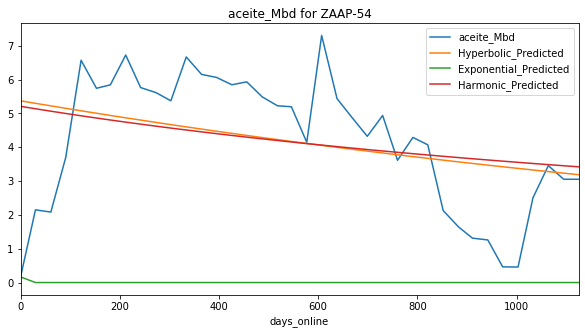

Exponential Fit Curve-fitted Variables: qi=2.1833574984748005, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.873794456351811, b=1.999544122024793, di=9.460063974437976e-20
Harmonic Fit Curve-fitted Variables: qi=6.87379147449999, di=4.1176077077549925e-19


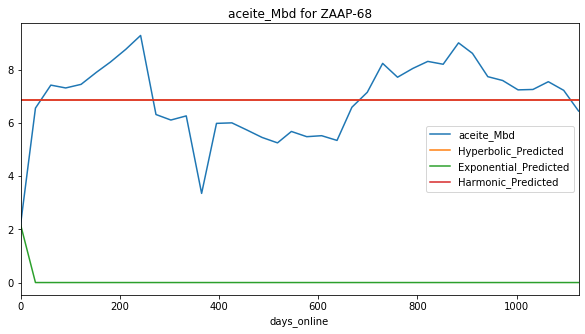

Exponential Fit Curve-fitted Variables: qi=1.8306919337840997, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.717764094252497, b=1.9999973060167708, di=2.523923360144798e-25
Harmonic Fit Curve-fitted Variables: qi=5.717765907951677, di=1.6675509648000923e-19


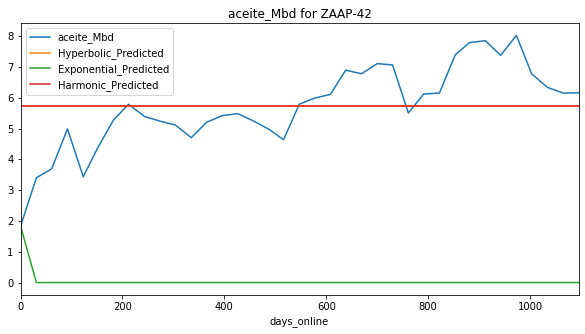

Exponential Fit Curve-fitted Variables: qi=1.7021130279970367, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=3.316059091592495, b=7.330199079178333e-07, di=0.000259046844357662
Harmonic Fit Curve-fitted Variables: qi=3.323458610604046, di=0.0002881392071557564


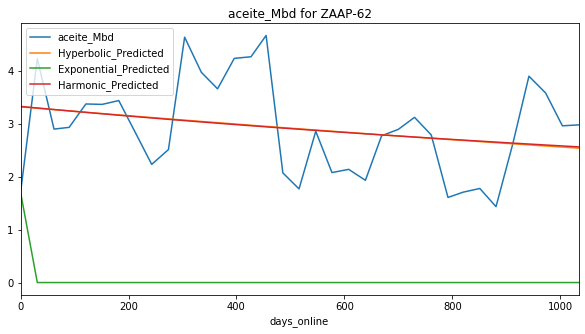

Exponential Fit Curve-fitted Variables: qi=6.204652165971509, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=7.915020122687768, b=1.9999999999969722, di=0.0007074428003536471
Harmonic Fit Curve-fitted Variables: qi=7.722548552049792, di=0.0005262614548749334


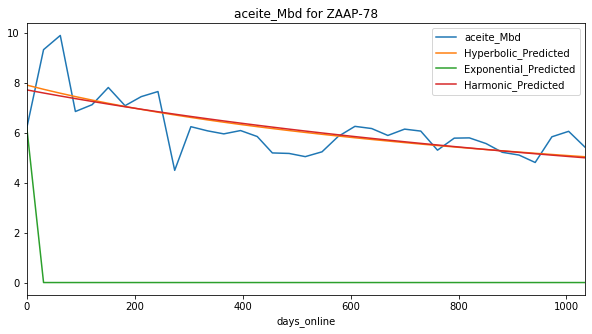

Exponential Fit Curve-fitted Variables: qi=2.0260908473106682, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.137153491765857, b=1.9996807900369047, di=9.277258893533168e-19
Harmonic Fit Curve-fitted Variables: qi=5.137158999629629, di=1.2783787679414473e-23


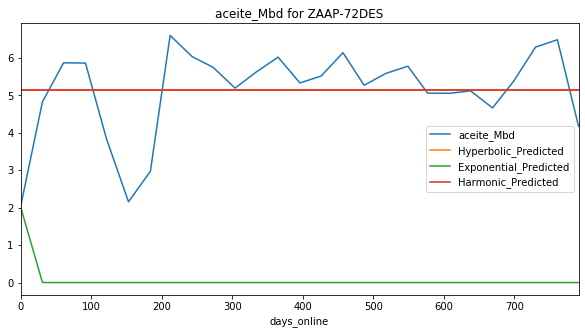

Exponential Fit Curve-fitted Variables: qi=0.9070634621312765, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=3.602938379221384, b=9.094808771449165e-13, di=0.002551229472274749
Harmonic Fit Curve-fitted Variables: qi=3.527025129279097, di=0.003697955072233434


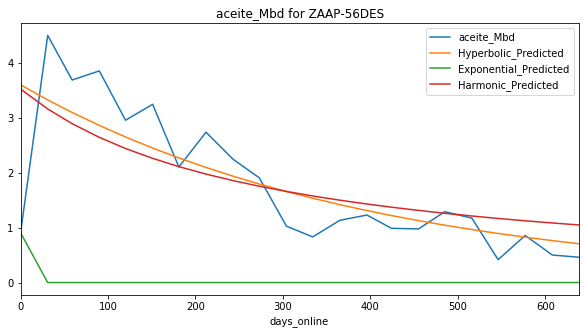

Exponential Fit Curve-fitted Variables: qi=0.8427340016887411, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=7.797155786072215, b=3.667050377255651e-16, di=0.0005932872418575371
Harmonic Fit Curve-fitted Variables: qi=7.669080188802723, di=0.0006092957424320761


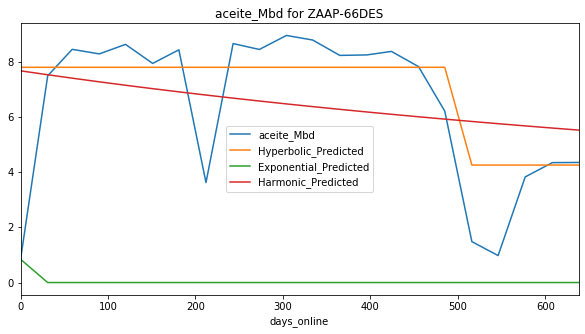

Exponential Fit Curve-fitted Variables: qi=2.6551622648776956, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.284434063093282, b=1.3151608971417872e-05, di=3.558860665554716e-15
Harmonic Fit Curve-fitted Variables: qi=6.284434087840603, di=9.431797541454551e-18


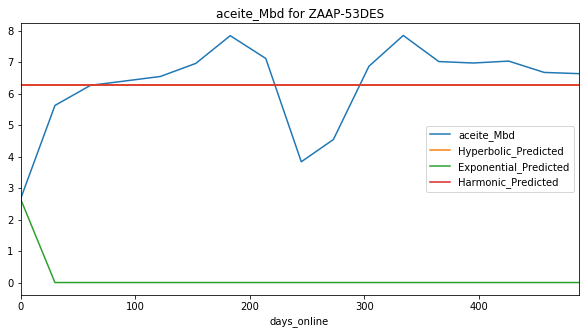

Exponential Fit Curve-fitted Variables: qi=4.1201418609661795, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.052963612230246, b=1.619677612163528e-05, di=4.146875086586131e-17
Harmonic Fit Curve-fitted Variables: qi=6.052963590625, di=4.4824222691781e-22


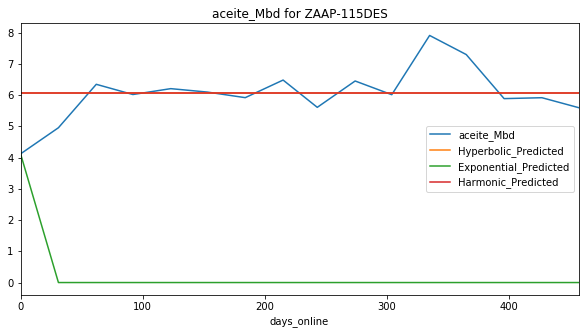

Exponential Fit Curve-fitted Variables: qi=3.598924252974459, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.964674830799997, b=1.9999999999999998, di=9.543082522756655e-21
Harmonic Fit Curve-fitted Variables: qi=5.964674830799981, di=1.0532246326547892e-19


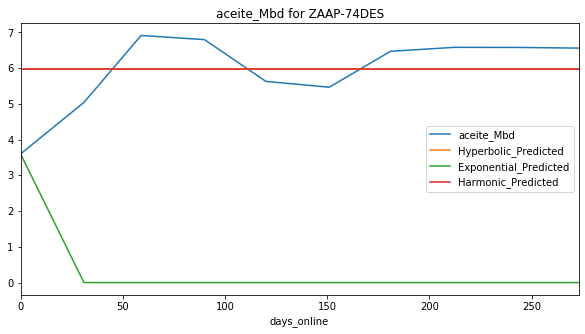

Exponential Fit Curve-fitted Variables: qi=0.26042788175670867, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.3604481397336211, b=1.999999997128599, di=2.678628420314445e-20
Harmonic Fit Curve-fitted Variables: qi=0.3604483036666534, di=8.517410816873416e-20


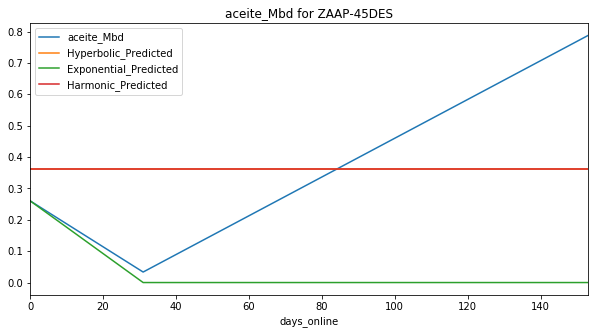

Exponential Fit Curve-fitted Variables: qi=3.792676821115055, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.180302891603066, b=1.9998875281446213, di=1.7035708276043849e-18
Harmonic Fit Curve-fitted Variables: qi=5.180310012494923, di=9.636082492077835e-17


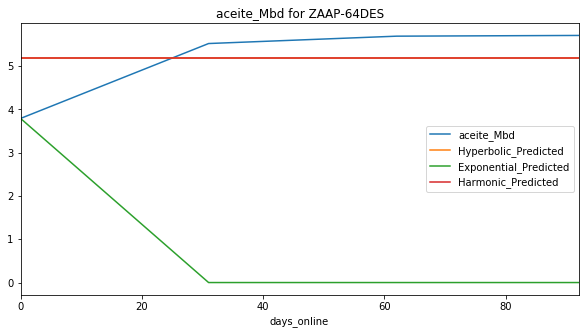

Exponential Fit Curve-fitted Variables: qi=1.078328550026818, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=2.951113867349839, b=1.9999999994620234, di=4.4497684164583143e-17
Harmonic Fit Curve-fitted Variables: qi=2.9511514453322985, di=1.038338695743307e-17


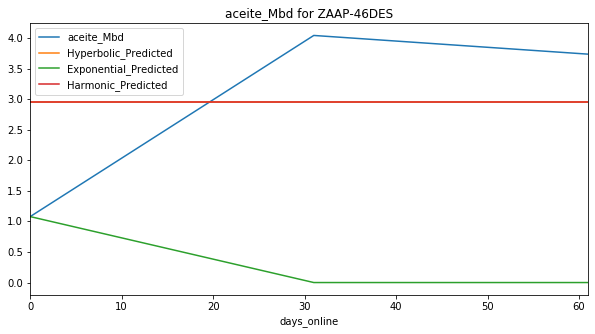

TypeError: unhashable type: 'numpy.ndarray'

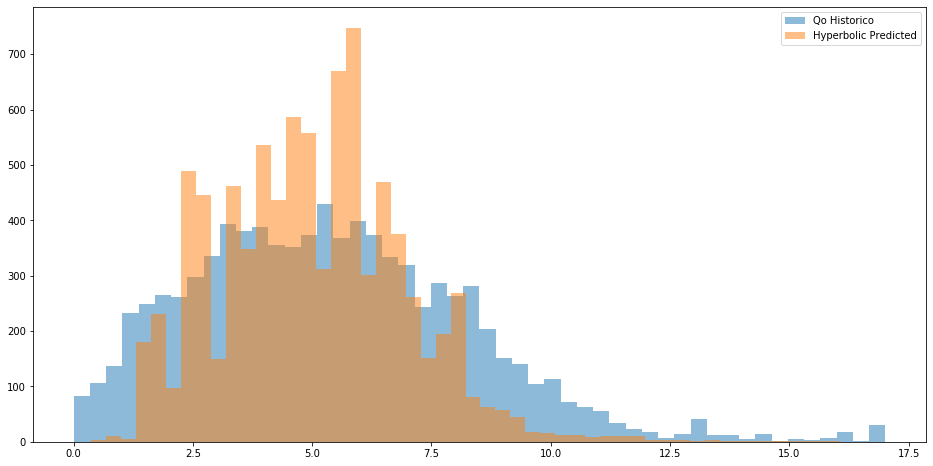

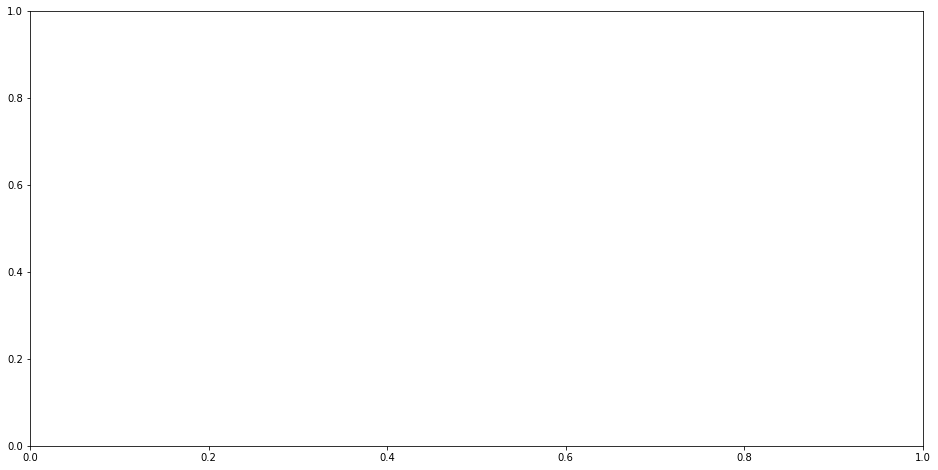

In [27]:
productividad()

In [ ]:
from scipy import stats

outliers=[]
def detect_outlier(data_1):
    global z_score
    global outliers
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return z_score

In [152]:
score=[]
def outlier_filter(data):
    global score
    global outliers
    threshold=3
    mean_1 = np.mean(data)
    std_1 =np.std(data)
    
    
    for y in data:
        z = (y - mean_1)/std_1 
        score.append(z)
    return score

In [153]:
df=campo
outliers=outlier_filter(df.aceite_Mbd)


In [154]:
display(score)

[-1.6806690065158356,
 -1.388330809107517,
 -0.9173180363450323,
 -1.8328773496031123,
 -0.9101129546202659,
 -0.9101126096979754,
 -0.7223827894531829,
 -0.9101129546202659,
 -0.6411401380878823,
 -1.0103239175031156,
 -0.5409422822520686,
 -1.0561261484491513,
 -0.49504899182135975,
 -1.0561261484491513,
 -0.49504899182135975,
 -1.0561295976720557,
 -0.4950676176250429,
 -1.0561261484491513,
 -0.49504899182135975,
 -1.0561295976720557,
 -0.4950676176250429,
 -1.0561261484491513,
 -0.49504899182135975,
 -1.055503218792637,
 -0.49404768241224506,
 -0.8913502167878123,
 -0.9163325933612774,
 -0.7907919171585007,
 -1.1574443118842777,
 -0.7907922620807912,
 -1.157444656806568,
 -0.7907919171585007,
 -1.1574443118842777,
 -0.7907922620807912,
 -1.157444656806568,
 -0.7907919171585007,
 -1.1574443118842777,
 -0.7907919171585007,
 -1.1574443118842777,
 -0.7907922620807912,
 -1.157444656806568,
 -0.7907919171585007,
 -1.1574443118842777,
 -0.7907922620807912,
 -1.157444656806568,
 -0.7907919

In [160]:
selected_row=score<=3

TypeError: '<=' not supported between instances of 'list' and 'int'